In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import constants as c
import numpy.random as npr
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%precision 4

'%.4f'

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

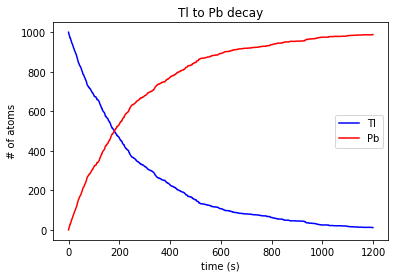

The graph depicts the classical profile of an exponential decay, where we can see that after 5 minutes almost 80% of Tl atoms have decayed and the two species reach equilibrium around after 180 seconds (conguently with the half-life).


In [2]:
tau = 3.052*60 #half-lieve in seconds to have the caracteristic tau of a 2^-t/tau decay

def p(t):
    alpha = -t/tau
    p = 1 - pow(2,alpha)
    return p

N = 1200

Tl_data = np.empty(N)

time = np.arange(0,N,1)
x = npr.random(1000)
CDF = 0.
for t in time:
    P = p(t)
    y = (x > P)            #list of survived Tl atoms
    Tl_data[t] = len(x[y])


Pb_data = np.ones(N)*1000-Tl_data            
plt.plot(time, Tl_data, color = 'blue',label = 'Tl')
plt.plot(time, Pb_data, color = 'red', label = 'Pb')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('# of atoms')
plt.title('Tl to Pb decay')
plt.show()
print('The graph depicts the classical profile of an exponential decay, where we can see that after 5 minutes almost 80% of Tl atoms have decayed and the two species reach equilibrium around after 180 seconds (conguently with the half-life).')

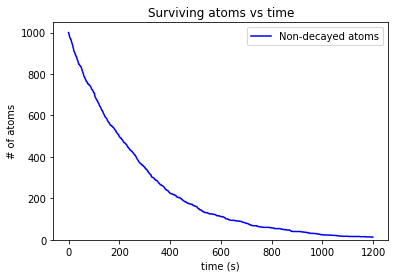

The profile matches the one we expect from an exponential random distribution


In [3]:
#2. Now, inverting the secondly given probability for time we find:
def f(z):
    t = -tau*np.log2(1-z)    #where t is a uniformly distributed RV in (0,1).
    return t

N = 1200
Z = npr.random(1000)
T = f(Z)
time = np.arange(0,N,1)
surv = np.empty(N)
for t in time:
    y = (T > t)
    surv[t] = len(T[y])

plt.plot(time, surv, color = 'blue',label = 'Non-decayed atoms')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('# of atoms')
plt.title('Surviving atoms vs time')
plt.ylim(0,)
plt.show()

print('The profile matches the one we expect from an exponential random distribution')

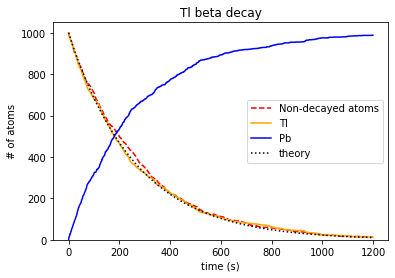

In [4]:
#Let's try to overimpose everything:
plt.plot(time, surv, color = 'red',label = 'Non-decayed atoms', ls='--')
plt.plot(time, Tl_data, color = 'orange',label = 'Tl')
plt.plot(time, Pb_data, color = 'blue', label = 'Pb')
th = 1000*(2**(-time/tau))
plt.plot(time, th, color = 'black', ls = ':',  label='theory')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('# of atoms')
plt.title('Tl beta decay')
plt.ylim(0,)
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

NOTE: if backscattering happens for $\theta$ > $\pi/2$, then we can focus on the region with $\theta \in [0,\pi]$ and see that $\tan(\theta/2)\le1$ for $\theta \le \pi/4$ and $\tan(\theta) > 1$ for $\theta > \pi/4$. 

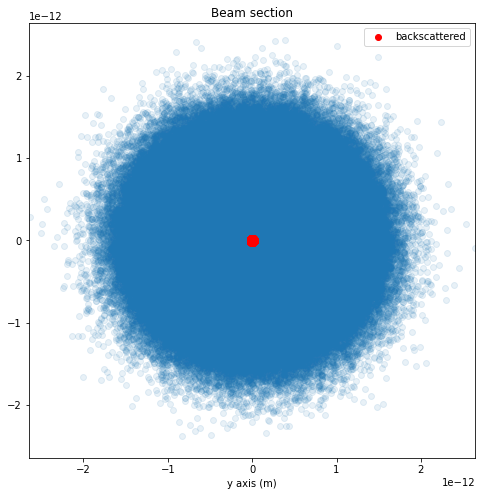

The fraction of particles that bounce back is 0.001596


In [5]:
Z = 79
e = c.elementary_charge
e0 = c.epsilon_0
E = 7.7*10**6*c.e #(in Joule)

def scatter(b):
    t = Z*e**2/(2*c.pi*e0*E*b)
    return t  #corresponding to tan(theta/2)

N = 10**6
a0 = 4*c.pi*c.epsilon_0*c.hbar**2/(c.m_e*c.e**2)   #Bohr radius
var = np.array([(a0/100)**2,0,0,(a0/100)**2]).reshape(2,2)

B = np.random.multivariate_normal([0,0], var, N).T

plt.figure(figsize=(8,8))
plt.xlim((-5*a0/100,5*a0/100))
plt.ylim((-5*a0/100,5*a0/100))
plt.xlabel('x axis (m)')
plt.xlabel('y axis (m)')
plt.scatter(B[0,:], B[1,:], alpha=0.1)
plt.title('Beam section')



B_modules = np.sqrt(B[0]**2 + B[1]**2)
Scatter_angles = scatter(B_modules)
mask = (Scatter_angles > 1)
Backscatter = Scatter_angles[mask]
B = B.T[mask].T
plt.scatter(B[0,:], B[1,:], alpha=1, color = 'red', label = 'backscattered')
plt.legend()
plt.show()



f = len(Backscatter) / len(Scatter_angles)
print('The fraction of particles that bounce back is', f)


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [6]:
#Firstly define the function:

def f(x):
    z = x*(2-x)
    return (np.sin(1/z))**2

#Define integration:
N = 10**6
count = 0          #counter for hit/miss (hm)
total = 0.         #sum for mean value (mv)
total_squares = 0. #sum for variance estimation (mv)
for i in range(N):
    x = npr.random()*2
    y = npr.random()
    total += f(x)
    total_squares += f(x)**2
    if y<f(x): count += 1
        
I_hm = 2*count/N
I_mv = 2*total/N
   
p = count/N                          #sampling probability of hitting by application of the method
sigma_hm = 2*np.sqrt(N*p*(1-p))/N    #Statistical error on the integral for hit&miss (assuming data distributing according to a binomial distribution with parameter p, from the theory)

varf = total_squares/N - (total/N)**2
sigma_mv = 2*np.sqrt(varf/N)            #value of std dev by theory on the mean value method

print('The value of integral with hit & miss method: %.4f +/- %.4f.' % (I_hm,sigma_hm))
print('The value of integral with mean value method: %.4f +/- %.4f.' % (I_mv,sigma_mv))

print('\nWe can notice how the two methods return different values, even though those are compatible within the statistical error. The hit and miss method results a little less precise, but both the relative errors are far below the 0.01%, for N = 10^6.')
    



The value of integral with hit & miss method: 1.4517 +/- 0.0009.
The value of integral with mean value method: 1.4511 +/- 0.0005.

We can notice how the two methods return different values, even though those are compatible within the statistical error. The hit and miss method results a little less precise, but both the relative errors are far below the 0.01%, for N = 10^6.


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10-Dimentional sphere



In [7]:
#Let's use the hit and miss method:

def f(x):                  #Define f for arbitrary dimention
    r2 = np.sum(x**2)      #Calculate sum of squared coordinates
    if r2 <= 1: return 1
    else: return 0

N = 10**5

#Dimention 2:
x = npr.random(2*N).reshape(-1,2)
counter = 0
for i in range(len(x)): counter += f(x[i])
I2 = 2**2 * counter / N

#Dimention 10:
x = npr.random(10*N).reshape(-1,10)
counter = 0
for i in range(len(x)): counter += f(x[i])
I10 = 2**10 *  counter / N

print('The area of a 2-dimentional sphere (circle) is:', I2, '(expected 3.1415)')
print('The hyper-volume of a 10-dimentional sphere is:', I10, '(expected 2.550)')


The area of a 2-dimentional sphere (circle) is: 3.15068 (expected 3.1415)
The hyper-volume of a 10-dimentional sphere is: 2.63168 (expected 2.550)


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [8]:
#Firstly let us make a pdf out of w(x) by setting a normalization factor in (0,1) (=1/2) and let us link it to an uniform distribution 
#by applying the inverse trasformation method (we find w(z) = z^2 with z uniformely ditributed between 0 and 1)


def w(x):
    return 1/(2*np.sqrt(x))

def f(x):
    return w(x)/(np.exp(x)+1)


N = 10**6
z = npr.random(N)**2.     #squared as required by inverse tfm

I = 2./N * np.sum(f(z)/w(z))   #value of integral w(z) in (0,1) equals 2)
print('The integral value is: {:.4f}'.format(I))


The integral value is: 0.8390
